In [1]:
import Pkg, Revise
using DrWatson
@quickactivate "sst-mot-analysis"

using GH19, TMI
using PythonPlot, PythonCall, CondaPkg

import DrWatson: datadir, srcdir

using NaNStatistics, Interpolations, 
      Statistics, LinearAlgebra

const mtpl = pyimport("matplotlib");
const cartopy = pyimport("cartopy");
const matplotlib = pyimport("matplotlib");
const sns = pyimport("seaborn");
const cm = pyimport("cmocean.cm")

mtpl.rcParams["figure.dpi"] = 100
ccrs = cartopy.crs

custom_style = Dict("text.color" => "black")
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style, font_scale = 1.2)
ccrs = cartopy.crs;
cfeature = cartopy.feature

    CondaPkg Found dependencies: /Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/CondaPkg.toml
    CondaPkg Found dependencies: /Users/anthonymeza/.julia/packages/PythonCall/L4cjh/CondaPkg.toml
    CondaPkg Found dependencies: /Users/anthonymeza/.julia/packages/PythonPlot/oS8x4/CondaPkg.toml
    CondaPkg Initialising pixi
             │ /Users/anthonymeza/.julia/artifacts/d2fecc2a9fa3eac2108d3e4d9d155e6ff5dfd0b2/bin/pixi
             │ init
             │ --format pixi
             └ /Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg
✔ Created /Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg/pixi.toml
    CondaPkg Wrote /Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg/pixi.toml
        

Python: <module 'cartopy.feature' from '/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/cartopy/feature/__init__.py'>

In [2]:
?sns.set_context

Python function `set_context`.

```text
Set the parameters that control the scaling of plot elements.

These parameters correspond to label size, line thickness, etc.
Calling this function modifies the global matplotlib `rcParams`. For more
information, see the :doc:`aesthetics tutorial <../tutorial/aesthetics>`.

The base context is "notebook", and the other contexts are "paper", "talk",
and "poster", which are version of the notebook parameters scaled by different
values. Font elements can also be scaled independently of (but relative to)
the other values.

See :func:`plotting_context` to get the parameter values.

Parameters
----------
context : dict, or one of {paper, notebook, talk, poster}
    A dictionary of parameters or the name of a preconfigured set.
font_scale : float, optional
    Separate scaling factor to independently scale the size of the
    font elements.
rc : dict, optional
    Parameter mappings to override the values in the preset seaborn
    context dictionaries. This only updates parameters that are
    considered part of the context definition.

Examples
--------

.. include:: ../docstrings/set_context.rst
```


In [3]:
include(srcdir("load_GH19.jl"))
include(srcdir("decompose_discrete.jl"))
include(srcdir("blocksum.jl"))
include(srcdir("IntersectionFunctions.jl"))

plot_map_and_zonal (generic function with 1 method)

In [4]:
function get_area_normalized_volume_filled_bc(TMIversion,Alu,γ)
    volume = volumefilled(TMIversion,Alu,γ); 
    volume = (10 .^ volume.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,γ.wet[:, :, 1],:V,"volume filled by surface gridcell per area","m³/m²")
    return 1 * volume
end

function get_volume_filled_bc(volume_normalized, γ, areao)
    volume = volume_normalized.tracer .* Float64.(areao.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,volume_normalized.wet,:V,"volume filled by surface gridcell","m³")
    return 1 * volume
end

function get_MOT_and_SST(TMIfile::String, γ::Grid)
    θ̄ = readfield(TMIfile, "θ", γ); #true mean
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

function get_MOT_and_SST(θ̄::Field, γ::Grid)
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

surfacecellarea(γ) = cellarea(γ)

surfacecellarea (generic function with 1 method)

#### Load in LGM and PI equillibrium temperatures

In [5]:
###### LOAD LGM ###########
TMI_version = "LGM_90x45x33_G14";
A, Alu, γ_lgm, TMIfile, L, B = config(TMI_version); println(sum(cellvolume(γ_lgm))) 
TMIfile = TMI.pkgdatadir("TMI_"*TMI_version*".nc")

volume_lgm_normalized = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_lgm)

volume_lgm = get_volume_filled_bc(volume_lgm_normalized, γ_lgm, surfacecellarea(γ_lgm))

θ̄_LGM_MOT, θ̄_LGM_SST = get_MOT_and_SST(TMIfile, γ_lgm);

###### LOAD PREINDUSTRIAL ###########
TMI_version = GH19.TMIversion();
A, Alu, γ_mod, TMIfile, L, B = config(TMI_version); 
TMIfile = TMI.pkgdatadir("TMI_"*TMI_version*".nc")

volume_mod_normalized_fine = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_mod)

volume_mod_fine = get_volume_filled_bc(volume_mod_normalized_fine, γ_mod, surfacecellarea(γ_mod))
θ̄GH19 = load_GH19_equillibrium()
θ̄_mod_MOT, θ̄_mod_SST_fine = get_MOT_and_SST(θ̄GH19, γ_mod);

A
  0.230790 seconds (676.09 k allocations: 69.791 MiB, 5.97% gc time, 81.02% compilation time)
Alu
  0.648974 seconds (586.66 k allocations: 506.641 MiB, 8.95% gc time, 10.43% compilation time)
L=
  0.081578 seconds (83.88 k allocations: 4.456 MiB, 95.28% compilation time)
B=
  0.018234 seconds (16.48 k allocations: 871.125 KiB, 89.79% compilation time)
1.4442375457929354e18
A
  0.047150 seconds (5.23 k allocations: 127.006 MiB, 19.56% gc time)
Alu
  4.093050 seconds (251 allocations: 2.810 GiB, 2.28% gc time, 0.12% compilation time)
L=
  0.205812 seconds (8.35 M allocations: 235.291 MiB, 12.38% gc time, 34.50% compilation time)
B=
  0.014809 seconds (6.19 k allocations: 7.271 MiB, 17.56% compilation time)
A
  0.037301 seconds (5.23 k allocations: 118.943 MiB, 30.20% gc time)
Alu
  4.356299 seconds (88 allocations: 2.810 GiB, 2.92% gc time)
L=
  0.131613 seconds (8.14 M allocations: 224.520 MiB, 5.18% gc time)
B=
  0.011978 seconds (6.14 k allocations: 7.270 MiB)


#### Coarse Grain PI output 

In [6]:
#coarse grain GH19 grid from 2x2 to 4x4
weights = volume_mod_fine.tracer ./ nansum(volume_mod_fine.tracer)
weights[isnan.(weights)] .= 0.0

oarea_mod_coarse = coarse_grain_boundary_condition(
    surfacecellarea(γ_mod), γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

volume_mod = coarse_grain_boundary_condition(
    volume_mod_fine, γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

θ̄_mod_SST = coarse_grain_boundary_condition(
    θ̄_mod_SST_fine, γ_mod, γ_lgm,
    2, 2;
    method = :average, use_area_weights = false, weights = weights, var = :θ);

#after coarsegraining, get the intersection between both grids
# θ̄_mod_SST, θ̄_LGM_SST = return_intersection(θ̄_mod_SST, θ̄_LGM_SST);
# volume_mod, volume_lgm = return_intersection(volume_mod, volume_lgm);

#### Calculate difference and overlap fields

In [7]:
SST_LGM = θ̄_LGM_SST.tracer
SST_PI = θ̄_mod_SST.tracer

ΔSST = SST_PI .- SST_LGM 

v_LGM = (volume_lgm.tracer ./ nansum(volume_lgm.tracer))
v_PI = (volume_mod.tracer ./ nansum(volume_mod.tracer))
Δv = v_PI .- v_LGM;

ΔSST_vlgm = ΔSST .* v_LGM;

SSTlgm_Δv = SST_LGM .* Δv;

ΔSST_Δv = ΔSST .* Δv;

ΔSSTv = ΔSST_vlgm .+ SSTlgm_Δv .+ ΔSST_Δv

90×45 Matrix{Float64}:
 NaN  NaN  NaN           NaN            …  -6.38482e-5    7.64583e-7
 NaN  NaN  NaN           NaN               -0.000464075   5.79429e-6
 NaN  NaN  NaN           NaN               -9.90209e-5    3.36093e-5
 NaN  NaN  NaN           NaN               -9.44998e-5    2.67733e-5
 NaN  NaN  NaN           NaN               -3.40207e-5    7.10792e-5
 NaN  NaN  NaN           NaN            …  -2.82308e-6    0.000122432
 NaN  NaN  NaN           NaN                8.24904e-5    8.85488e-5
 NaN  NaN  NaN           NaN                1.9146e-5     0.000131804
 NaN  NaN  NaN           NaN                0.000132838   9.51398e-5
 NaN  NaN  NaN           NaN                0.000708973   0.000680233
 NaN  NaN  NaN           NaN            …   0.00100729    0.0933729
 NaN  NaN  NaN           NaN                3.33209e-5    0.000538843
 NaN  NaN  NaN           NaN               -9.66684e-5    0.000152078
   ⋮                                    ⋱                
 NaN  NaN  NaN    

In [8]:
lat_area_average(x, γ) = vec((nansum(x .* cellarea(γ).tracer, dims = 1) ./ nansum(cellarea(γ).tracer, dims = 1)))
lat_sum(x) = vec((nansum(x, dims = 1)))

SST_LGM_lat = lat_area_average(SST_LGM, γ_lgm)[:]
ΔSST_lat = lat_area_average(ΔSST, γ_lgm)[:]

lgm_lat_volumes = lat_sum(v_LGM)
Δv_lat = lat_sum(Δv)

ΔSST_vlgm_lat = lat_sum(ΔSST_vlgm)
ΔSST_Δv_lat = lat_sum(ΔSST_Δv);
SSTlgm_Δv_lat = lat_sum(SSTlgm_Δv);
ΔSSTv_lat = lat_sum(ΔSSTv);


#### Plot SST, v fields and their differences 

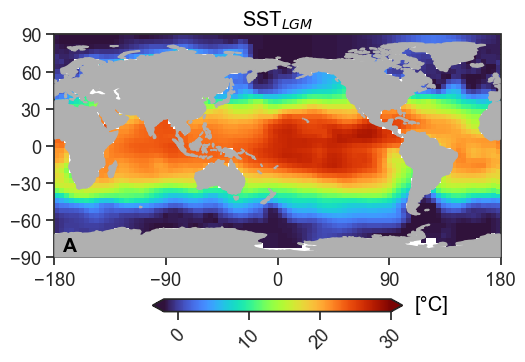

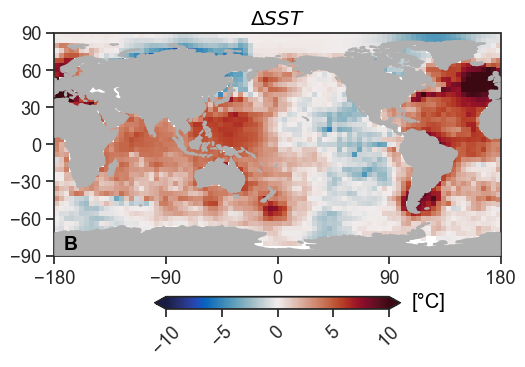

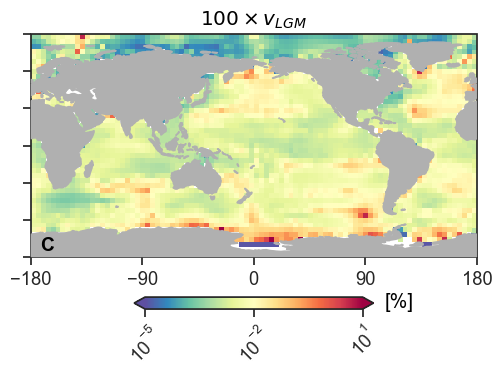

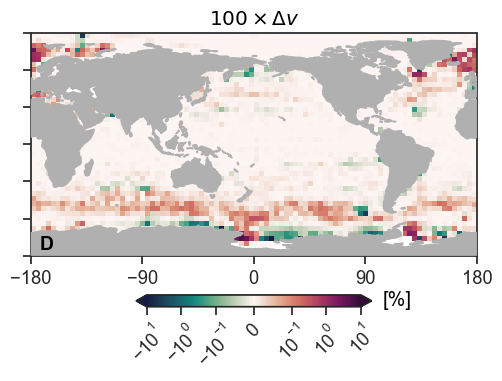

(Figure(<py Figure size 1500x500 with 2 Axes>), <py GeoAxes: title={'center': '$100 \\times \\Delta v$'}>)

In [9]:
###### PLOT LGM SST #######
plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  SST_LGM',
  SST_LGM_lat;
  map_norm    = matplotlib.colors.Normalize(vmin=-2, vmax=30),
  cmap        = "turbo",
  map_title   = "SST" * L"_{LGM}",
  cb_label    = "[°C]",
  zonal_xticks= -2:5:30,
  zonal_title = "Zonally Averaged\n" * "SST" * L"_{LGM}",
  savepath    = plotsdir("3A.SST_LGM.png"), plot_letter = "A"
)

###### PLOT ΔSST #######

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST',
  ΔSST_lat;
  map_norm    = matplotlib.colors.Normalize(vmin=-10, vmax=10),
  cmap        = cm.balance,
  map_title   = L"\Delta SST ",
  cb_label    = "[°C]",
  zonal_xticks= -1:5,
  zonal_title = "Zonally Averaged\n" * L"\Delta" * "SST",
  savepath    = plotsdir("3B.ΔSST.png"), plot_letter = "B"
)

###### PLOT LGM v #######

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  100 .* v_LGM',
  100 .* lgm_lat_volumes;
  map_norm    = matplotlib.colors.LogNorm(vmin=1e-5, vmax=1e1),
  cmap        = "Spectral_r",
  map_title   = L"100 \times v_{LGM}",
  cb_label    = "[%]",
  zonal_xticks= 0:10:45,
  zonal_title = "Zonally Summed\n" * L"100 \times v_{LGM}",
  savepath    = plotsdir("3C.v_lgm_latitude.png"), plot_letter = "C", hide_yticklabels = true
)

###### PLOT LGM Δv #######
plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  100 .* Δv',
  100 .* Δv_lat;
  map_norm    = matplotlib.colors.SymLogNorm(linthresh=1e-1, vmin=-1e1, vmax=1e1),
  cmap        = cm.curl,
  map_title   = L"100 \times \Delta v",
  cb_label    = "[%]",
  zonal_xticks= -30:15:30,
  zonal_title = "Zonally Summed\n" * L"100 \times \Delta v",
  savepath    = plotsdir("3D.Δv_lgm_latitude.png"), plot_letter = "D", hide_yticklabels = true
)

#### Plot MOT spatial decomposition

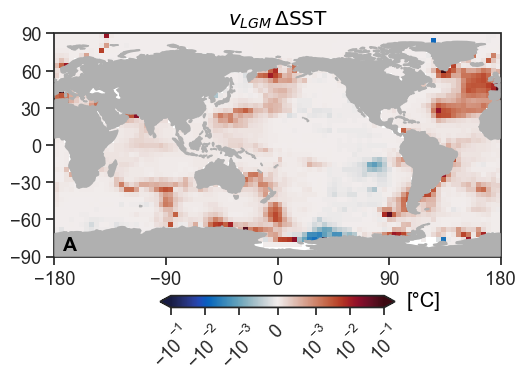

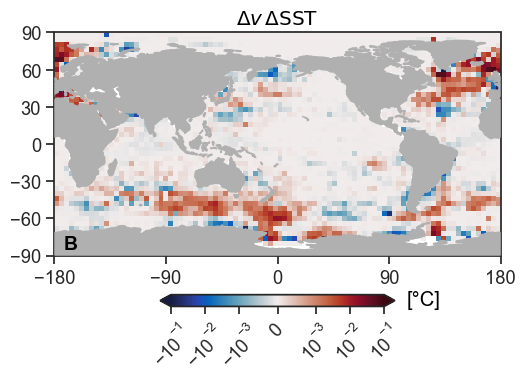

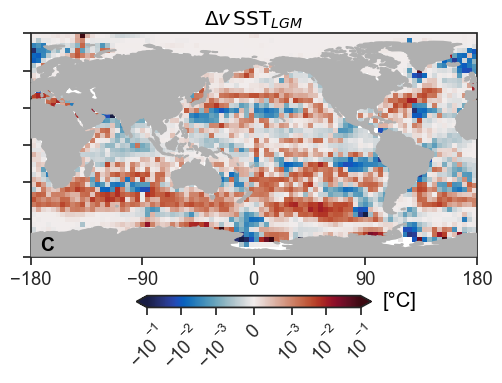

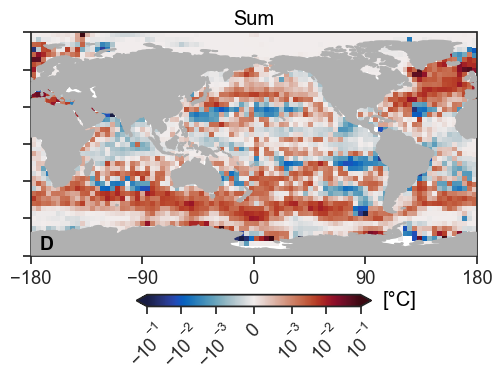

(Figure(<py Figure size 1500x500 with 2 Axes>), <py GeoAxes: title={'center': 'Sum'}>)

In [10]:
norm =  matplotlib.colors.SymLogNorm(linthresh=1e-3, vmin=-1e-1, vmax=1e-1)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST_vlgm', ΔSST_vlgm_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"v_{LGM}\,\Delta\mathrm{SST}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"v_{LGM} \Delta SST",
  savepath    = plotsdir("4A.MOT_decomp_vLGM_ΔSST.png"), plot_letter = "A"
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST_Δv', ΔSST_Δv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"\Delta v\,\Delta\mathrm{SST}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("4B.MOT_decomp_Δv_ΔSST.png"), plot_letter = "B"
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  SSTlgm_Δv', SSTlgm_Δv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"\Delta v\,\mathrm{SST}_{LGM}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("4C.MOT_decomp_Δv_SSTLGM.png"), plot_letter = "C", hide_yticklabels = true
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSSTv', ΔSSTv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = "Sum",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("4D.MOT_decomp_SUM.png"), plot_letter = "D", hide_yticklabels = true
)

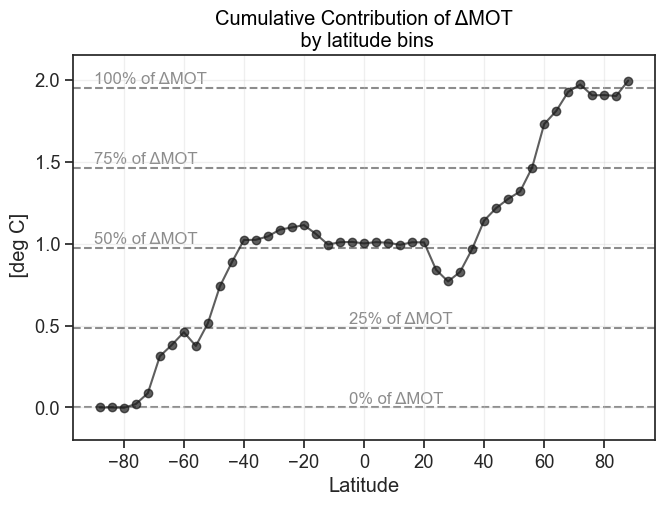

Python: None

In [34]:
fig, ax = subplots(figsize = (7.5, 5)) 

ΔSSTv_lat_cumsum = cumsum(nansum(ΔSSTv, dims = 1)[:])
percentages = [0, 25, 50, 75, 100]

final_value = (θ̄_mod_MOT - θ̄_LGM_MOT)
percentage_values = [final_value * p / 100 for p in percentages]

xlocs = [-5, -5, -90, -90, -90]
for (i, p) in enumerate(percentages)
    val = percentage_values[i]
    lab_alp = 0.9
    # Find the index closest to the percentage value in the cumulative sum
    ax.axhline(y=val, color="gray", linestyle="--", alpha = lab_alp, zorder = 0)
    ax.text(xlocs[i], val + 0.05, string(p) * "% of ΔMOT", fontsize=12, va="center", ha="left", color = "grey", alpha = lab_alp, zorder = 0)
end

ax.plot(γ_lgm.lat, ΔSSTv_lat_cumsum, marker='o', c = "k", alpha = 0.7)

ax.set_xticks(collect(-80:20:80))
ax.set_ylabel(" [deg C]")

ax.set_xlabel("Latitude")

ax.set_title("Cumulative Contribution of ΔMOT\n by latitude bins")
ax.grid(alpha = 0.3)
ax.set_ylim(-0.2, final_value + 0.2)
fig.savefig(plotsdir("5.dMOT_Latitude_Bins_cumsum.png"), dpi = 200, bbox_inches = "tight")